In [ ]:
!pip install tslearn
!pip install pyts

In [1]:
import numpy as np
import pandas as pd

In [2]:
agg_df = pd.read_csv('../data_ready/agg/batting_norm_agg.csv')

In [23]:
agg_df['hof'].sum() / len(agg_df)

0.05280263669863359

In [420]:
agg2[agg2['hof']].sort_values('g')

,Unnamed: 0,Unnamed: 0.1,ab,bb,double,g,h,hbp,hr,r,rbi,sb,sh,so,triple,years_played,hof
player_id,,,,,,,,,,,,,,,,,
brownwi02,10592,10920,-0.465167,-0.665236,-0.377410,-0.674567,-0.526152,-0.461885,-0.299984,-0.551212,-0.464428,0.187113,-0.729381,-0.519118,-0.575775,1.0,True
irvinmo01,11421,11788,6.603449,8.807964,4.803380,6.609862,7.416037,9.530594,9.662144,6.773189,10.089170,4.957773,-0.765241,3.414820,8.350465,8.0,True
hafeych01,3737,3861,12.321097,7.983065,19.091223,11.529930,13.803409,14.668519,23.235878,13.903553,17.199094,8.695445,4.445297,17.597934,10.686704,13.0,True
camparo01,11012,11346,14.153932,15.011866,12.308864,13.736424,14.082515,12.369475,29.090691,14.581532,23.779343,3.670171,2.375898,15.080184,2.371652,10.0,True
wilsoha01,3601,3725,13.881088,22.589546,13.935954,13.908143,14.449937,6.813193,38.749986,18.008864,25.228414,5.245698,7.282968,34.855209,11.491814,12.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ripkeca01,25987,26480,40.925585,34.059953,40.960233,37.979274,40.824505,18.550806,43.485983,40.166549,43.555044,-0.432205,-0.688196,21.101473,12.226009,21.0,True
murraed02,23975,24468,39.150338,43.185970,38.235980,38.546247,41.621386,3.937850,57.153712,40.600355,53.298252,3.559524,-0.680393,29.500643,5.989076,21.0,True
yastrca01,15796,16271,41.835125,67.892039,53.900083,39.887946,45.061597,8.871536,51.765388,49.597076,53.654928,19.230504,-0.015463,27.049242,16.240953,23.0,True


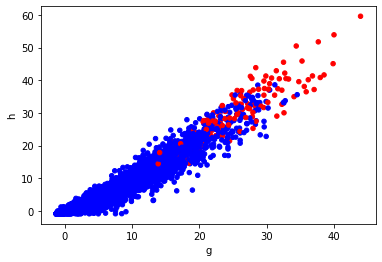

In [24]:
agg2 = agg_df.groupby('player_id').max('years_played')
agg2.plot.scatter('g', 'h', c=['red' if agg2.iloc[i]['hof'] else 'blue' for i in range(len(agg2))])

In [3]:
agg_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

,ab,bb,double,g,h,hbp,hr,player_id,r,rbi,sb,sh,so,triple,years_played,hof
0,-0.661588,-0.438871,-0.640879,-0.705525,-0.583966,-0.539028,-0.388342,acostme01,-0.539369,-0.609924,-0.335788,-0.665060,-0.794309,-0.310270,1.0,False
1,-1.145500,-0.634319,-1.124076,-1.026475,-1.017650,-1.125153,-0.813317,acostme01,-0.903027,-1.153566,-0.636014,-1.424980,-0.892177,-0.404662,2.0,False
2,-1.161406,-0.031041,-1.378979,-0.693510,-1.160762,-0.056680,-1.235447,acostme01,-0.879855,-1.079926,-0.389503,-1.058649,-1.112142,-0.762685,3.0,False
3,-1.954610,-0.615781,-2.052017,-1.647343,-1.893377,-0.604941,-1.638442,acostme01,-1.575987,-1.775687,-0.956969,-1.764229,-2.108656,-1.364642,4.0,False
4,-1.744661,-0.229190,-2.314481,-1.438181,-1.531243,-1.148788,-2.011442,acostme01,-1.190280,-1.700775,-0.966303,-1.027140,-2.202136,-0.952990,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43686,-0.448198,-0.350041,-0.506754,-0.542378,-0.443520,-0.452528,-0.364299,turnetr01,-0.407728,-0.547344,0.027295,-0.478008,-0.390894,-0.427949,1.0,False
43687,0.781068,0.410928,0.186854,0.614127,0.573732,0.309030,0.325219,urshegi01,0.382690,0.258928,-0.357982,0.058954,0.748672,0.186402,1.0,False
43688,-0.659393,-0.567460,-0.605841,-1.099213,-0.623035,-0.452528,-0.502202,waldrky02,-0.605333,-0.587657,-0.357982,-0.478008,-0.663400,-0.427949,1.0,False
43689,-0.551088,-0.513105,-0.308580,-0.949296,-0.503358,-0.452528,-0.364299,willima07,-0.486770,-0.466716,-0.357982,-0.478008,-0.613853,-0.427949,1.0,False


In [4]:
career_length = agg_df.groupby('player_id')['years_played'].max()
players_5yrs = career_length[career_length > 5]

# Classifying the time series samples

### Approaches:
* Zero pad, and throw into one time series classifier  
* Train one time series classifier for each length (1-year careers, 2-year careers, etc.)



In [11]:
X_all = np.load('../data_ready/ts/X_all.npy')
y_all = np.load('../data_ready/y_all.npy')
years_played_all = np.load('../data_ready/years_played_all.npy')
player_ids_all = np.load('../data_ready/player_ids_all.npy', allow_pickle=True)

### train / test split by HOF / non-hof players

In [12]:
hof_players = agg_df[agg_df['hof']]['player_id'].unique()
non_hof_players = agg_df[~agg_df['hof']]['player_id'].unique()
np.random.seed(1)
np.random.shuffle(hof_players), np.random.shuffle(non_hof_players);

In [13]:
train_ratio = 0.7
zeros_ratio = 1
n_hof, n_non = len(hof_players), len(non_hof_players)

train_hof, test_hof = hof_players[:int(n_hof*train_ratio)], hof_players[int(n_hof*train_ratio):]
train_non, test_non = non_hof_players[:int(n_non*train_ratio)], non_hof_players[int(n_non*train_ratio):]

train_non_sample = train_non[:int(len(train_non)*zeros_ratio)]

train_players, test_players = set(np.concatenate((train_hof, train_non_sample))), set(np.concatenate((test_hof, test_non)))
train_idxs = np.array([i for i in range(len(player_ids_all)) if player_ids_all[i] in train_players])
test_idxs = np.array([i for i in range(len(player_ids_all)) if player_ids_all[i] in test_players])

In [14]:
test_hof

array(['brownwi02', 'gehrich01', 'snidedu01', 'camparo01', 'sislege01',
       'guerrvl01', 'gosligo01', 'perezto01', 'riceji01', 'winfida01',
       'smithoz01', 'benchjo01', 'bankser01', 'martied01', 'bottoji01',
       'lazzeto01', 'cronijo01', 'ripkeca01', 'traynpi01', 'morgajo02',
       'manushe01', 'molitpa01', 'wilsoha01', 'reesepe01', 'simmoal01',
       'ricesa01', 'gwynnto01', 'killeha01', 'robinfr02', 'heilmha01',
       'jackstr01', 'irvinmo01', 'willibi01', 'kellyge01', 'mazerbi01',
       'friscfr01', 'beltrad01', 'clemero01', 'applilu01'], dtype=object)

In [15]:
X_train, X_test = X_all[train_idxs], X_all[test_idxs]
y_train, y_test = y_all[train_idxs], y_all[test_idxs]
train_years_played, test_years_played = years_played_all[train_idxs], years_played_all[test_idxs]
train_player_ids, test_player_ids = player_ids_all[train_idxs], player_ids_all[test_idxs]

## Undo zero-padding + group idxs by # of samples

In [199]:
X_train_unpad, X_test_unpad = [], []
idx_train_by_year, idx_test_by_year = [[] for _ in range(26)], [[] for _ in range(26)]
for i in range(X_train.shape[0]):
    yrs_played = int(train_years_played[i])
    idx_train_by_year[yrs_played].append(i)
    X_train_unpad.append(X_train[i][:yrs_played])
for i in range(X_test.shape[0]):
    yrs_played = int(test_years_played[i])
    idx_test_by_year[yrs_played].append(i)
    X_test_unpad.append(X_test[i][:yrs_played])

### % of HOFers + # of samples for each career length

In [170]:
print('training data')
train_hist = [(np.sum(y_train[idx_train_by_year[i]]) / len(idx_train_by_year[i]), len(idx_train_by_year[i])) for i in range(1, 26)]
display(train_hist)
print('test data')
test_hist = [(np.sum(y_test[idx_test_by_year[i]]) / len(idx_test_by_year[i]), len(idx_test_by_year[i])) for i in range(1, 26)]
test_hist

training data


[(0.04365079365079365, 2016),
 (0.05648267008985879, 1558),
 (0.0682699767261443, 1289),
 (0.08014571948998178, 1098),
 (0.09292502639915523, 947),
 (0.10438908659549229, 843),
 (0.11780455153949129, 747),
 (0.13273001508295626, 663),
 (0.1543859649122807, 570),
 (0.1825726141078838, 482),
 (0.2119700748129676, 401),
 (0.24561403508771928, 342),
 (0.31297709923664124, 262),
 (0.34101382488479265, 217),
 (0.39325842696629215, 178),
 (0.4701492537313433, 134),
 (0.5263157894736842, 114),
 (0.6710526315789473, 76),
 (0.7543859649122807, 57),
 (0.9166666666666666, 36),
 (0.9615384615384616, 26),
 (1.0, 18),
 (1.0, 8),
 (1.0, 3),
 (1.0, 1)]

test data


<ipython-input-170-ff41d8fec79c>:5: RuntimeWarning: invalid value encountered in long_scalars
  test_hist = [(np.sum(y_test[idx_test_by_year[i]]) / len(idx_test_by_year[i]), len(idx_test_by_year[i])) for i in range(1, 26)]


[(0.018095238095238095, 2100),
 (0.023125, 1600),
 (0.028136882129277566, 1315),
 (0.03268551236749117, 1132),
 (0.03707414829659319, 998),
 (0.041666666666666664, 888),
 (0.04798962386511025, 771),
 (0.0549777117384844, 673),
 (0.060810810810810814, 592),
 (0.0728744939271255, 494),
 (0.08333333333333333, 420),
 (0.10174418604651163, 344),
 (0.12546125461254612, 271),
 (0.1588785046728972, 214),
 (0.19642857142857142, 168),
 (0.22962962962962963, 135),
 (0.25742574257425743, 101),
 (0.30434782608695654, 69),
 (0.37209302325581395, 43),
 (0.4444444444444444, 27),
 (0.5384615384615384, 13),
 (0.4, 10),
 (0.3333333333333333, 3),
 (0.0, 1),
 (nan, 0)]

## Random HOF and non-HOF samples:


In [171]:
np.random.seed(1)
hof_rand, non_hof_rand = np.random.choice(np.where(y_train == 1)[0]), np.random.choice(np.where(y_train == 0)[0])

In [172]:
for i in (hof_rand, non_hof_rand):
    display(X_train_unpad[i], train_years_played[i], train_player_ids[i])

array([[ 1.1397146 ,  2.02168166,  1.67783737,  1.08165126,  0.79330746,
         0.4307195 ,  1.43247401,  1.64431773,  0.89903381,  3.21099742,
         0.01175137,  2.02244887,  0.97868075],
       [ 1.83910241,  1.49446174,  2.36819163,  1.85646077,  1.6838071 ,
         0.92022933,  2.13481438,  2.35548097,  1.15177433,  2.77268543,
        -0.66056693,  1.58710637,  3.81924303]])

2.0

'bondsba01'

array([[-0.74951754, -0.66633881, -0.60523593, -0.95311561, -0.67348963,
        -0.56572792, -0.42212953, -0.69881213, -0.68285082, -0.57575304,
        -0.75457976, -1.0194754 , -0.35802334]])

1.0

'kolseka01'

# Models

### ROCKET 
hinge: train in 70 sec, 90 epochs  
log: train in 150 sec, 101 epochs





Trying 70/30 splits because 80/20 gives too few 'full career' test samples of HOFers

In [523]:
import numpy as np
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

from sktime.transformers.series_as_features.rocket import Rocket

In [524]:
def eval_rocket(rocket_pipeline, X_test, y_test):
    ones_preds, zeros_preds, ones_score, zeros_score = None, None, None, None
    n_ones = np.sum(y_test)
    n_zeros = np.sum(1-y_test)
    try:
#         print('ones ({})'.format(np.sum(y_test)))
        ones_preds = rocket_pipeline.predict(X_test[y_test == 1])
        ones_score = np.sum(ones_preds) / len(ones_preds)
#         print(ones_score)
    except:
        pass
    try:
#         print('zeros ({})'.format(np.sum(1-y_test)))
        zeros_preds = rocket_pipeline.predict(X_test[y_test == 0])
        zeros_score = np.sum(1-zeros_preds) / len(zeros_preds)
#         print(zeros_score)
    except:
        pass
    
    return ones_preds, zeros_preds, (ones_score, n_ones), (zeros_score, n_zeros)

In [536]:
def eval_rocket_by_year(rocket_pipeline, X_test, y_test, agg_df, test_player_ids, test_years_played, test_zeros_ratio=1, years_before_end=-1):
    
    if years_before_end != -1:
        player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
        test_idxs_full_careers = [i for i in range(len(X_test)) if player_career_lengths[test_player_ids[i]] - years_before_end == test_years_played[i]]

        X_test_full_careers, y_test_full_careers = X_test[test_idxs_full_careers], y_test[test_idxs_full_careers]
        
        test_0s = np.where(y_test_full_careers==0)[0]
        np.random.seed(1)
        idxs_sample_0s = np.random.choice(test_0s, size=int(len(test_0s) * test_zeros_ratio), replace=False)
        
        idxs = np.concatenate((idxs_sample_0s, np.where(y_test_full_careers==1)[0]))
        if years_before_end == 0:
            print(classification_report(y_test_full_careers[idxs], rocket_pipeline.predict(X_test_full_careers[idxs])))
            print(percent_fp_got_votes(y_test_full_careers[idxs], rocket_pipeline.predict(X_test_full_careers[idxs]), test_player_ids[test_idxs_full_careers][idxs]))
        
        return eval_rocket(rocket_pipeline, X_test_full_careers[idxs], y_test_full_careers[idxs])
    else:
        return eval_rocket(rocket_pipeline, X_test, y_test)
        

In [538]:
rocket_pipeline_sgd = make_pipeline(Rocket(), SGDClassifier(eta0=0.001, learning_rate='adaptive', verbose=1, class_weight={0:0.01, 1:1.0}))

In [ ]:
rocket_pipeline_sgd.fit(X_train, y_train)

In [540]:
_, _, ones_score, zeros_score = eval_rocket_by_year(rocket_pipeline_sgd, X_test, y_test, agg_df, test_player_ids, test_years_played, years_before_end=0)
ones_score, zeros_score

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2062
           1       0.10      0.45      0.16        38

    accuracy                           0.92      2100
   macro avg       0.54      0.69      0.56      2100
weighted avg       0.97      0.92      0.94      2100

0.05806451612903226


((0.4473684210526316, 38), (0.9248302618816683, 2062))

In [542]:
ones_preds, zeros_preds, ones_scores, zeros_scores = [], [], [], []
for i in range(26):
    ones_pred, zeros_pred, ones_score, zeros_score = eval_rocket_by_year(rocket_pipeline_sgd, X_test, y_test, agg_df, test_player_ids, test_years_played, years_before_end=i)
    ones_scores.append(ones_score), zeros_scores.append(zeros_score)
    ones_preds.append(ones_pred), zeros_preds.append(zeros_pred)
ones_scores, zeros_scores

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2062
           1       0.10      0.45      0.16        38

    accuracy                           0.92      2100
   macro avg       0.54      0.69      0.56      2100
weighted avg       0.97      0.92      0.94      2100

0.05806451612903226


([(0.4473684210526316, 38),
  (0.3783783783783784, 37),
  (0.32432432432432434, 37),
  (0.32432432432432434, 37),
  (0.32432432432432434, 37),
  (0.2972972972972973, 37),
  (0.1891891891891892, 37),
  (0.13513513513513514, 37),
  (0.19444444444444445, 36),
  (0.1111111111111111, 36),
  (0.11428571428571428, 35),
  (0.11428571428571428, 35),
  (0.08823529411764706, 34),
  (0.14705882352941177, 34),
  (0.15151515151515152, 33),
  (0.06451612903225806, 31),
  (0.07692307692307693, 26),
  (0.19047619047619047, 21),
  (0.1875, 16),
  (0.08333333333333333, 12),
  (0.42857142857142855, 7),
  (0.0, 4),
  (0.0, 1),
  (None, 0),
  (None, 0),
  (None, 0)],
 [(0.9248302618816683, 2062),
  (0.9520153550863724, 1563),
  (0.9491392801251957, 1278),
  (0.9452054794520548, 1095),
  (0.9531737773152965, 961),
  (0.9435957696827262, 851),
  (0.9564032697547684, 734),
  (0.940251572327044, 636),
  (0.935251798561151, 556),
  (0.9192139737991266, 458),
  (0.9246753246753247, 385),
  (0.9061488673139159, 30

In [315]:
[x.max(axis=1).mean(axis=0) for x in ones_preds if x is not None]

AxisError: axis 1 is out of bounds for array of dimension 1

In [553]:
rocket_pipeline_lr = make_pipeline(Rocket(), LogisticRegression(verbose=1, class_weight={0:0.1, 1:1}))

In [554]:
rocket_pipeline_lr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.3s finished


Pipeline(steps=[('rocket', Rocket()),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 0.01, 1: 1}, verbose=1))])

In [555]:
ones_preds_lr, zeros_preds_lr, ones_scores_lr, zeros_scores_lr = [], [], [], []
for i in range(26):
    ones_pred, zeros_pred, ones_score, zeros_score = eval_rocket_by_year(rocket_pipeline_lr, X_test, y_test, agg_df, test_player_ids, test_years_played, years_before_end=i)
    ones_scores_lr.append(ones_score), zeros_scores_lr.append(zeros_score)
    ones_preds_lr.append(ones_pred), zeros_preds_lr.append(zeros_pred)

              precision    recall  f1-score   support

           0       0.99      0.91      0.94      2062
           1       0.06      0.32      0.10        38

    accuracy                           0.90      2100
   macro avg       0.52      0.61      0.52      2100
weighted avg       0.97      0.90      0.93      2100

0.061855670103092786


In [ ]:
[x.max(axis=1).mean(axis=0) for x in ones_preds_lr if x is not None]

In [556]:
ones_scores_lr, zeros_scores_lr

([(0.3157894736842105, 38),
  (0.24324324324324326, 37),
  (0.2702702702702703, 37),
  (0.21621621621621623, 37),
  (0.1891891891891892, 37),
  (0.13513513513513514, 37),
  (0.10810810810810811, 37),
  (0.1891891891891892, 37),
  (0.19444444444444445, 36),
  (0.16666666666666666, 36),
  (0.17142857142857143, 35),
  (0.17142857142857143, 35),
  (0.14705882352941177, 34),
  (0.11764705882352941, 34),
  (0.24242424242424243, 33),
  (0.12903225806451613, 31),
  (0.15384615384615385, 26),
  (0.19047619047619047, 21),
  (0.1875, 16),
  (0.25, 12),
  (0.2857142857142857, 7),
  (0.25, 4),
  (0.0, 1),
  (None, 0),
  (None, 0),
  (None, 0)],
 [(0.9059165858389913, 2062),
  (0.9315419065898912, 1563),
  (0.9280125195618153, 1278),
  (0.9324200913242009, 1095),
  (0.9406867845993756, 961),
  (0.918918918918919, 851),
  (0.9182561307901907, 734),
  (0.9025157232704403, 636),
  (0.9046762589928058, 556),
  (0.8799126637554585, 458),
  (0.8727272727272727, 385),
  (0.8576051779935275, 309),
  (0.8691

### LSTM

#### best settings: all 0s, class weight 0.05, 50 epochs, LSTM 20, Dense 50

In [ ]:
pip install tensorflow

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [8]:
def train_model(trainX, trainy):
    verbose, epochs, batch_size = 1, 50, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(20, input_shape=(n_timesteps,n_features)))
#     model.add(LSTM(100))    , return_sequences=True
#     model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight={0:0.05, 1:1.0})
    return model

In [9]:
def eval_lstm(lstm, X_test, y_test):
    ones_preds, zeros_preds, ones_score, zeros_score = None, None, None, None
    n_ones = np.sum(y_test)
    n_zeros = np.sum(1-y_test)
    try:
#         print('ones ({})'.format(np.sum(y_test)))
        ones_preds = lstm.predict(X_test[y_test == 1], batch_size=64, verbose=0)

        ones_score = np.sum(np.argmax(ones_preds, axis=1)) / len(ones_preds)
#         print(ones_score)
    except:
        pass
    try:
#         print('zeros ({})'.format(np.sum(1-y_test)))
        zeros_preds = lstm.predict(X_test[y_test == 0], batch_size=64, verbose=0)
        zeros_score = np.sum(1-np.argmax(zeros_preds, axis=1)) / len(zeros_preds)
#         print(zeros_score)
    except:
        pass
    
    return ones_preds, zeros_preds, (ones_score, n_ones), (zeros_score, n_zeros)

In [10]:
def eval_lstm_by_year(lstm, X_test, y_test, agg_df, test_player_ids, test_years_played, test_zeros_ratio=1, years_before_end=-1):
    
    if years_before_end != -1:
        player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
        test_idxs_full_careers = [i for i in range(len(X_test)) if player_career_lengths[test_player_ids[i]] - years_before_end == test_years_played[i]]

        X_test_full_careers, y_test_full_careers = X_test[test_idxs_full_careers], y_test[test_idxs_full_careers]
        
        test_0s = np.where(y_test_full_careers==0)[0]
        np.random.seed(1)
        idxs_sample_0s = np.random.choice(test_0s, size=int(len(test_0s) * test_zeros_ratio), replace=False)
        
        idxs = np.concatenate((idxs_sample_0s, np.where(y_test_full_careers==1)[0]))
        if years_before_end == 0:
            print(classification_report(y_test_full_careers[idxs], np.argmax(lstm.predict(X_test_full_careers[idxs]), axis=1)))
            print(percent_fp_got_votes(y_test_full_careers[idxs], np.argmax(lstm.predict(X_test_full_careers[idxs]), axis=1), test_player_ids[test_idxs_full_careers][idxs]))
        return eval_lstm(lstm, X_test_full_careers[idxs], y_test_full_careers[idxs])
    else:
        return eval_rocket(lstm, X_test, y_test)

In [16]:
sum(y_train) / len(y_train)

0.05647294302666381

In [398]:
eval_lstm_by_year(good_lstm, X_test, y_test, agg_df, test_player_ids, test_years_played, years_before_end=1)[-2:]

((0.9459459459459459, 37), (0.889955214331414, 1563))

In [606]:
lstm = train_model(X_train, to_categorical(y_train))

Epoch 1/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0306 - accuracy: 0.6612
Epoch 2/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0244 - accuracy: 0.7547
Epoch 3/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0225 - accuracy: 0.7888
Epoch 4/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0211 - accuracy: 0.7949
Epoch 5/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0204 - accuracy: 0.8088
Epoch 6/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0200 - accuracy: 0.8177
Epoch 7/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0190 - accuracy: 0.8233
Epoch 8/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0182 - accuracy: 0.8415
Epoch 9/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0176 - accuracy: 0.8459
Epoch 10/50
438/438 [==============================] - 3s 6ms/step - loss: 0.0176 - accuracy: 0.8518

In [613]:
_, _, o, z = eval_lstm_by_year(lstm, X_test, y_test, agg_df, train_player_ids, train_years_played, years_before_end=0)
o, z

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2138
           1       0.29      0.72      0.42       144

    accuracy                           0.87      2282
   macro avg       0.64      0.80      0.67      2282
weighted avg       0.94      0.87      0.90      2282

0.13545816733067728


((0.7222222222222222, 144), (0.882600561272217, 2138))

In [17]:
lstm = load_model('better_lstm/')

In [19]:
def percent_fp_got_votes(y_true, y_preds, idx_player_ids): # about half
    fp_idxs = np.where((y_true == 0) & (y_preds == 1))[0]
    fp_players = idx_player_ids[fp_idxs]
    hof = pd.read_csv('../data_normalized/hall_of_fame.csv')
    return np.mean(np.isin(fp_players, hof['player_id']))

In [20]:
ones_preds_lstm, zeros_preds_lstm, ones_scores_lstm, zeros_scores_lstm = [], [], [], []
for i in range(26):
    ones_pred, zeros_pred, ones_score, zeros_score = eval_lstm_by_year(lstm, X_test, y_test, agg_df, test_player_ids, test_years_played, years_before_end=i)
    ones_scores_lstm.append(ones_score), zeros_scores_lstm.append(zeros_score)
    ones_preds_lstm.append(ones_pred), zeros_preds_lstm.append(zeros_pred)
ones_scores_lstm, zeros_scores_lstm

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2062
           1       0.27      0.79      0.41        38

    accuracy                           0.96      2100
   macro avg       0.63      0.88      0.69      2100
weighted avg       0.98      0.96      0.97      2100

0.475


([(0.7894736842105263, 38),
  (0.8378378378378378, 37),
  (0.8108108108108109, 37),
  (0.8108108108108109, 37),
  (0.8378378378378378, 37),
  (0.8378378378378378, 37),
  (0.8648648648648649, 37),
  (0.7567567567567568, 37),
  (0.75, 36),
  (0.7222222222222222, 36),
  (0.7428571428571429, 35),
  (0.6857142857142857, 35),
  (0.6470588235294118, 34),
  (0.7352941176470589, 34),
  (0.6060606060606061, 33),
  (0.5806451612903226, 31),
  (0.4230769230769231, 26),
  (0.47619047619047616, 21),
  (0.5, 16),
  (0.5, 12),
  (0.2857142857142857, 7),
  (0.25, 4),
  (0.0, 1),
  (None, 0),
  (None, 0),
  (None, 0)],
 [(0.9612027158098934, 2062),
  (0.9321817018554063, 1563),
  (0.9100156494522692, 1278),
  (0.8849315068493151, 1095),
  (0.8626430801248699, 961),
  (0.8401880141010576, 851),
  (0.8501362397820164, 734),
  (0.8380503144654088, 636),
  (0.8165467625899281, 556),
  (0.8013100436681223, 458),
  (0.787012987012987, 385),
  (0.7928802588996764, 309),
  (0.7890295358649789, 237),
  (0.811111


                   precision    recall  f1-score   support

               0       1.00      0.96      0.98      2062
               1       0.27      0.79      0.41        38

        accuracy                           0.96      2100
       macro avg       0.63      0.88      0.69      2100
    weighted avg       0.98      0.96      0.97      2100
good_lstm ^


                  precision    recall  f1-score   support

               0       1.00      0.93      0.97      2062
               1       0.20      0.92      0.33        38

        accuracy                           0.93      2100
       macro avg       0.60      0.93      0.65      2100
    weighted avg       0.98      0.93      0.95      2100
    
better_lstm ^

In [370]:
ones_scores_lstm, zeros_scores_lstm # lstm25, dense50, 50 epoch, .05 0s weight

([(0.9210526315789473, 38),
  (0.9459459459459459, 37),
  (0.9459459459459459, 37),
  (0.9459459459459459, 37),
  (0.9459459459459459, 37),
  (0.8918918918918919, 37),
  (0.918918918918919, 37),
  (0.8378378378378378, 37),
  (0.8333333333333334, 36),
  (0.8055555555555556, 36),
  (0.8, 35),
  (0.7428571428571429, 35),
  (0.7058823529411765, 34),
  (0.7352941176470589, 34),
  (0.5454545454545454, 33),
  (0.5483870967741935, 31),
  (0.38461538461538464, 26),
  (0.42857142857142855, 21),
  (0.4375, 16),
  (0.5, 12),
  (0.42857142857142855, 7),
  (0.0, 4),
  (0.0, 1),
  (None, 0),
  (None, 0),
  (None, 0)],
 [(0.9340446168768186, 2062),
  (0.889955214331414, 1563),
  (0.8544600938967136, 1278),
  (0.8356164383561644, 1095),
  (0.7960457856399584, 961),
  (0.7861339600470035, 851),
  (0.7806539509536785, 734),
  (0.7625786163522013, 636),
  (0.7661870503597122, 556),
  (0.7663755458515283, 458),
  (0.7688311688311689, 385),
  (0.7346278317152104, 309),
  (0.7426160337552743, 237),
  (0.7777

In [381]:
X_player = X_all[np.where(player_ids_all == 'gehrilo01')]
lstm.predict(X_player)

array([[6.5569341e-01, 3.4430656e-01],
       [8.2225472e-01, 1.7774528e-01],
       [1.4185956e-01, 8.5814047e-01],
       [9.7852433e-03, 9.9021471e-01],
       [6.7260936e-03, 9.9327385e-01],
       [4.9038115e-03, 9.9509615e-01],
       [3.9083729e-03, 9.9609166e-01],
       [2.8881221e-03, 9.9711180e-01],
       [1.7733071e-03, 9.9822670e-01],
       [1.0424535e-03, 9.9895751e-01],
       [5.5245234e-04, 9.9944752e-01],
       [3.1591905e-04, 9.9968410e-01],
       [1.3631680e-04, 9.9986362e-01],
       [4.3392138e-05, 9.9995661e-01],
       [1.5405252e-05, 9.9998462e-01],
       [8.4139618e-05, 9.9991584e-01],
       [3.4838930e-02, 9.6516109e-01]], dtype=float32)

### DTW + KNN

In [326]:
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier 

In [327]:
def eval_knn(knn, X_test, y_test):
    ones_preds, zeros_preds = None, None
    try:
        ones_preds = knn.predict([X_test[i] for i in np.where(y_test == 1)[0]])
        print(np.sum(ones_preds) / len(ones_preds))
    except:
        pass
    try:
        zeros_preds = knn.predict([X_test[i] for i in np.where(y_test == 0)[0]])
        print(np.sum(1-zeros_preds) / len(zeros_preds))
    except:
        pass
    
    return ones_preds, zeros_preds

### 1 big knn (0-padded)

#### eval on players at end of career

In [619]:
def eval_end_career_knn(X_train, y_train, X_test, y_test, agg_df, train_player_ids, test_player_ids, train_years_played, test_years_played, train_zeros_ratio=1, test_zeros_ratio=1, end_careers=True):
    if train_zeros_ratio != 1:
        np.random.seed(1)
        idxs_train_0s = np.where(y_train == 0)[0]
        idxs_train_1s = np.where(y_train == 1)[0]
        ratio_0s = np.random.choice(idxs_train_0s, size=int(len(idxs_train_0s) * train_zeros_ratio), replace=False)
        X_train_ratio_0s = [X_train[i] for i in ratio_0s] + [X_train[i] for i in idxs_train_1s]
        y_train_ratio_0s = [y_train[i] for i in ratio_0s] + [y_train[i] for i in idxs_train_1s]
    else:
        X_train_ratio_0s = X_train
        y_train_ratio_0s = y_train

    knn_all = KNeighborsTimeSeriesClassifier(n_neighbors=1)
    knn_all.fit(X_train_ratio_0s, y_train_ratio_0s)
    
    if end_careers:
        player_career_lengths = agg_df.groupby('player_id')['years_played'].max().to_dict()
        test_idxs_full_careers = [i for i in range(len(X_test)) if player_career_lengths[test_player_ids[i]] == test_years_played[i]]
        display(len(test_idxs_full_careers) / len(X_test))

        X_test_full_careers, y_test_full_careers = X_test[test_idxs_full_careers], y_test[test_idxs_full_careers]
        
        
        
        test_0s = np.where(y_test_full_careers==0)[0]
        np.random.seed(1)
        idxs_sample_0s = np.random.choice(test_0s, size=int(len(test_0s) * test_zeros_ratio))
        
        idxs = np.concatenate((idxs_sample_0s, np.where(y_test_full_careers==1)[0]))
#         print(idxs_sample_0s)
        print(idxs)
        eval_knn(knn_all, X_test_full_careers[idxs], y_test_full_careers[idxs])
    else:
        eval_knn(knn_all, X_test, y_test)

In [620]:
eval_end_career_knn(X_train, y_train, X_test, y_test, agg_df, train_player_ids, test_player_ids, train_years_played, test_years_played, train_zeros_ratio=0.1, test_zeros_ratio=0.05, end_careers=True)

0.16960103375868196

[1093  246 1129  933  988  148  132 1237 1335 1313  371  265  690  579
  778 1562 1925 1144 2063 1061  333 1372 1957  330 1323  752  445  652
  557 1128 1446 1513 1372  530  512 1647 1881 1395  911 1356   15   25
 1530 1964 1341 1675 1078 1838 1184 1338  159  327  668 1347 1715  254
 1407 1249  956 1789 1209  719 1380 1428 1906 1832 1312  476 1835  582
  484 1513 1573 1647  739 1133 1099  547 1607  899 1836  993   99  282
 1964  917  156 1775  625  504  156  911  893 1793 1927  279 1925 1911
  341 1625 1460   20 2005   49   85   92  144  163  185  196  213  225
  233  239  259  262  312  451  567  576  580  599  657  673  684  713
  716  753  820  833  873  990 1006 1063 1068 1122 1130 1226 1706 1725
 2024]
0.2894736842105263
0.9029126213592233


## knn on specific year of careers

In [615]:
def eval_year_knn(yr, X_train, y_train, X_test, y_test, idx_train_by_year, idx_test_by_year, zeros_ratio=1):
    idxs_train_yr, idxs_test_yr = np.array(idx_train_by_year[yr]), np.array(idx_test_by_year[yr])
    
    X_train_yr = [X_train_unpad[i] for i in idx_train_by_year[yr]]
    y_train_yr = y_train[idx_train_by_year[yr]]
    X_test_yr = [X_test_unpad[i] for i in idx_test_by_year[yr]]
    y_test_yr = y_test[idx_test_by_year[yr]]
    
    if zeros_ratio != 1:
        np.random.seed(1)
        idxs_yr_train_0s = np.where(y_train_yr == 0)[0]
        idxs_yr_train_1s = np.where(y_train_yr == 1)[0]
        ratio_0s = np.random.choice(idxs_yr_train_0s, size=int(len(idxs_yr_train_0s) * zeros_ratio), replace=False)
        X_train_yr_ratio_0s = [X_train_yr[i] for i in ratio_0s] + [X_train_yr[i] for i in idxs_yr_train_1s]
        y_train_yr_ratio_0s = [y_train_yr[i] for i in ratio_0s] + [y_train_yr[i] for i in idxs_yr_train_1s]
    else:
        X_train_yr_ratio_0s = X_train_yr
        y_train_yr_ratio_0s = y_train_yr
    
    display(np.where(y_test_yr == 1)[0])
    
    knn_yr = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='dtw')
    knn_yr.fit(X_train_yr_ratio_0s, y_train_yr_ratio_0s)
    
    eval_knn(knn_yr, X_test_yr, y_test_yr)

In [616]:
eval_year_knn(15, X_train, y_train, X_test, y_test, idx_train_by_year, idx_test_by_year, zeros_ratio=0.5)

array([  4,   5,   7,   9,  11,  13,  14,  15,  16,  17,  19,  22,  34,
        39,  41,  44,  45,  49,  57,  62,  82,  88,  90,  93,  94, 136,
       137, 142, 145, 148, 156, 162, 167])

0.36363636363636365
0.8296296296296296
